# Projeto 2 - Megadados

## Imports

In [3]:
import pyspark
import math
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Spark

In [4]:
sc = pyspark.SparkContext(appName = "teste")

In [5]:
sc

<SparkContext master=local[*] appName=teste>

## RDD

In [6]:
rdd = sc.sequenceFile("part-00000")

In [7]:
N_docs = rdd.count()
N_docs

36133

## Início da Análise

*RRDs específicos: iphone, android e ambos*

In [8]:
rdd_ip = rdd.filter(lambda x: "iphone" in x[1] and not "android" in x[1]) 
rdd_an = rdd.filter(lambda x: "android" in x[1] and not "iphone" in x[1])
rdd_in = rdd.filter(lambda x: "iphone" in x[1] and "android" in x[1])

### Funções para contar palavras e documentos

In [9]:
def conta_palavras(item):
    url, conteudo = item 
    palavras = conteudo.strip().split()
    return [(palavra.lower(), 1) for palavra in palavras]

def conta_documentos(item):
    url, conteudo = item 
    palavras = conteudo.strip().split()
    return [(palavra.lower(), 1) for palavra in set(palavras)]

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

*RRDs específicos: iphone, android e ambos*

In [10]:
rdd_iphone = rdd_ip.flatMap(conta_palavras).reduceByKey(junta_contagens)
rdd_android = rdd_an.flatMap(conta_palavras).reduceByKey(junta_contagens)
rdd_inter = rdd_in.flatMap(conta_palavras).reduceByKey(junta_contagens)

In [11]:
rdd_iphone_docs = rdd_ip.flatMap(conta_documentos).reduceByKey(junta_contagens)
rdd_android_docs = rdd_an.flatMap(conta_documentos).reduceByKey(junta_contagens)
rdd_inter_docs = rdd_in.flatMap(conta_documentos).reduceByKey(junta_contagens)

In [12]:
doc_min = 10
doc_max = 0.70* N_docs
def filtra_doc_freq(item):
    contagem = item[1]
    return (contagem < doc_max) and (contagem >= doc_min)

In [13]:
rdd_iphone_docs_filtrado = rdd_iphone_docs.filter(filtra_doc_freq)
rdd_android_docs_filtrado = rdd_android_docs.filter(filtra_doc_freq)
rdd_inter_docs_filtrado = rdd_inter_docs.filter(filtra_doc_freq)

In [14]:
def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(N_docs / contagem)
    return (palavra,idf)

def computa_freq(item):
    palavra, contagem = item
    freq = math.log10(1 + contagem)
    return (palavra,freq)

In [15]:
rdd_iphone_idf = rdd_iphone_docs_filtrado.map(computa_idf)
rdd_iphone_freq = rdd_iphone.map(computa_freq)

rdd_android_idf = rdd_android_docs_filtrado.map(computa_idf)
rdd_android_freq = rdd_android.map(computa_freq)

rdd_inter_idf = rdd_inter_docs_filtrado.map(computa_idf)
rdd_inter_freq = rdd_inter.map(computa_freq)

In [16]:
def computa_rel(item):
    palavra, contagem = item
    freq, idf = contagem
    relevancia = freq*idf
    return (palavra, relevancia)

In [38]:
def conversor(item):
    dic = {}
    for a, b in item: 
        dic[a] = b 
    return dic

In [31]:
rdd_inter_join = rdd_inter_freq.join(rdd_inter_idf)
rdd_inter_rel = rdd_inter_join.map(computa_rel)

list_inter_rel = rdd_inter_rel.takeOrdered(100, key=lambda x: -x[1])
#list_inter_rel
inter_df = pd.DataFrame(list_inter_rel, columns=["palavra", "relevancia"])
inter_csv = inter_df.to_csv("inter.csv", index=False)

In [35]:
table_inter = pd.read_csv("inter.csv", sep=",")
table_inter

palavra  relevancia
0     celular   10.918930
1          de   10.652260
2      gratis   10.187428
3    rastrear   10.099324
4         for    9.743733
..        ...         ...
95  celulares    6.122222
96     ouvido    6.120005
97        ser    6.091145
98     número    6.075371
99        das    6.009983

[100 rows x 2 columns]

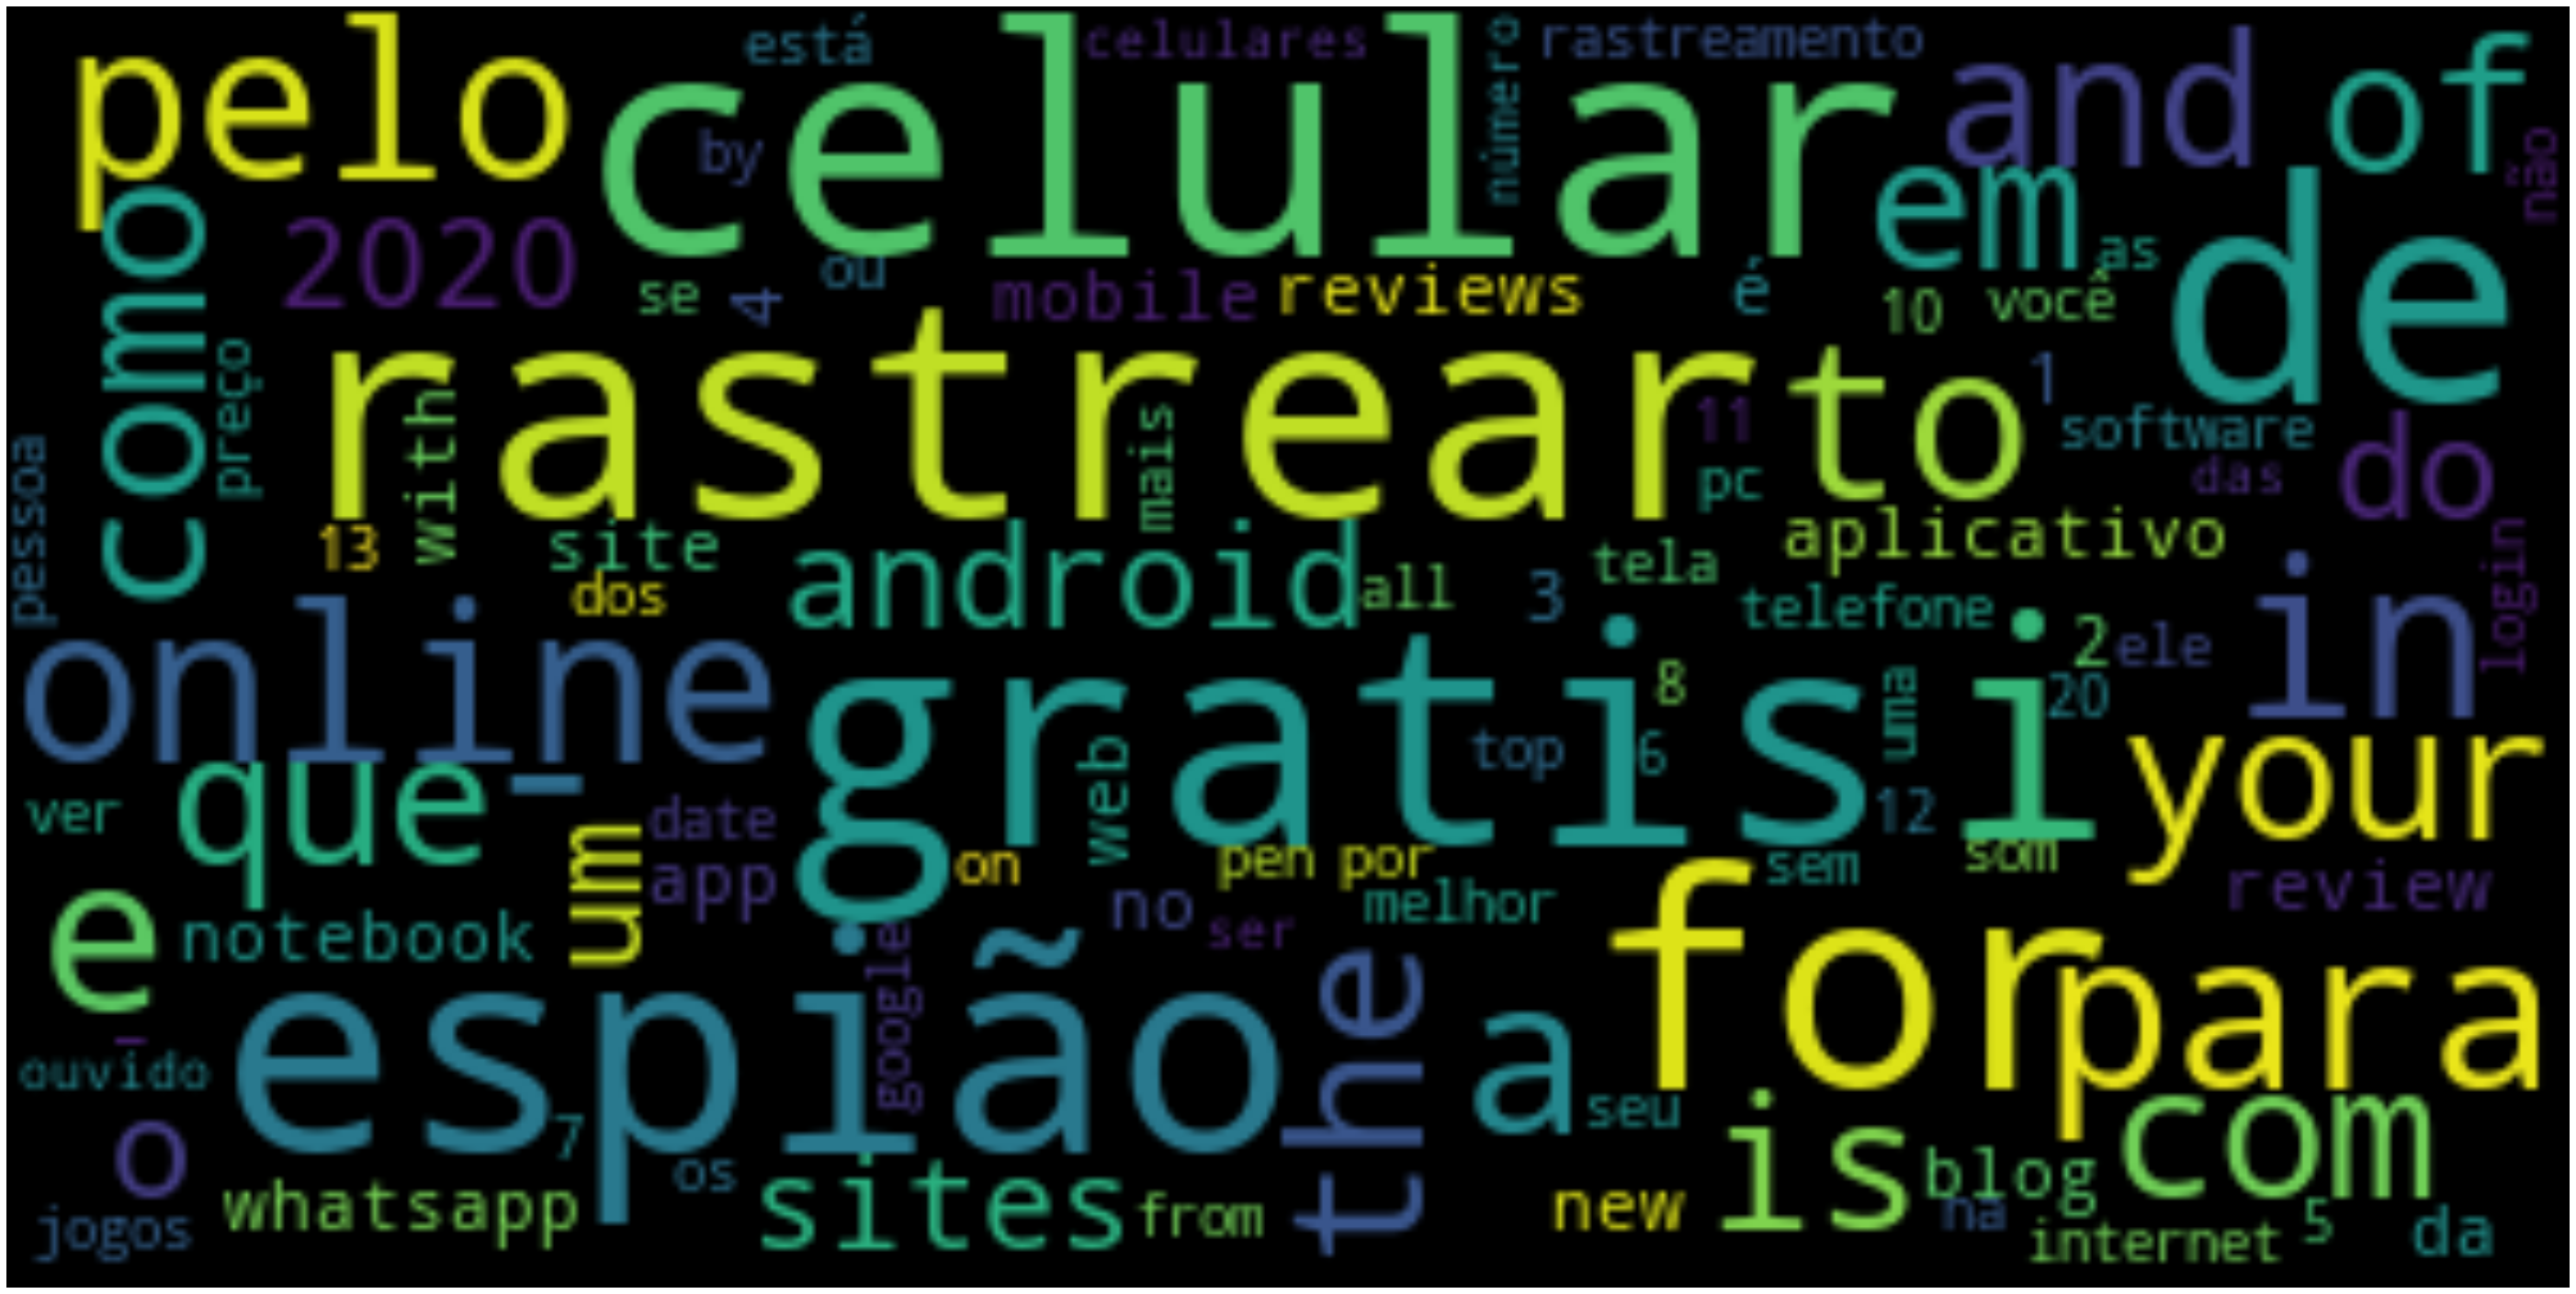

In [41]:
wordcloud_inter = WordCloud(max_font_size=50, max_words=100, background_color="black").generate_from_frequencies(frequencies=conversor(list_inter_rel))
wordcloud_inter.to_file("wordcloud_inter.png")
plt.figure(figsize = (50,50))
plt.imshow(wordcloud_inter, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
rdd_iphone_join = rdd_iphone_freq.join(rdd_iphone_idf)
rdd_iphone_rel = rdd_iphone_join.map(computa_rel)

list_iphone_rel = rdd_iphone_rel.takeOrdered(100, key=lambda x: -x[1])
#list_iphone_rel
iphone_df = pd.DataFrame(list_iphone_rel, columns=["palavra", "relevancia"])
iphone_csv = iphone_df.to_csv("iphone.csv", index=False)

In [36]:
table_iphone = pd.read_csv("iphone.csv", sep=",")
table_iphone

palavra  relevancia
0   responder   11.426943
1      partir   11.025486
2          às   10.375051
3          vc   10.310292
4          de   10.227592
..        ...         ...
95    website    8.148768
96       time    8.136740
97      great    8.136284
98        web    8.121308
99        pra    8.118988

[100 rows x 2 columns]

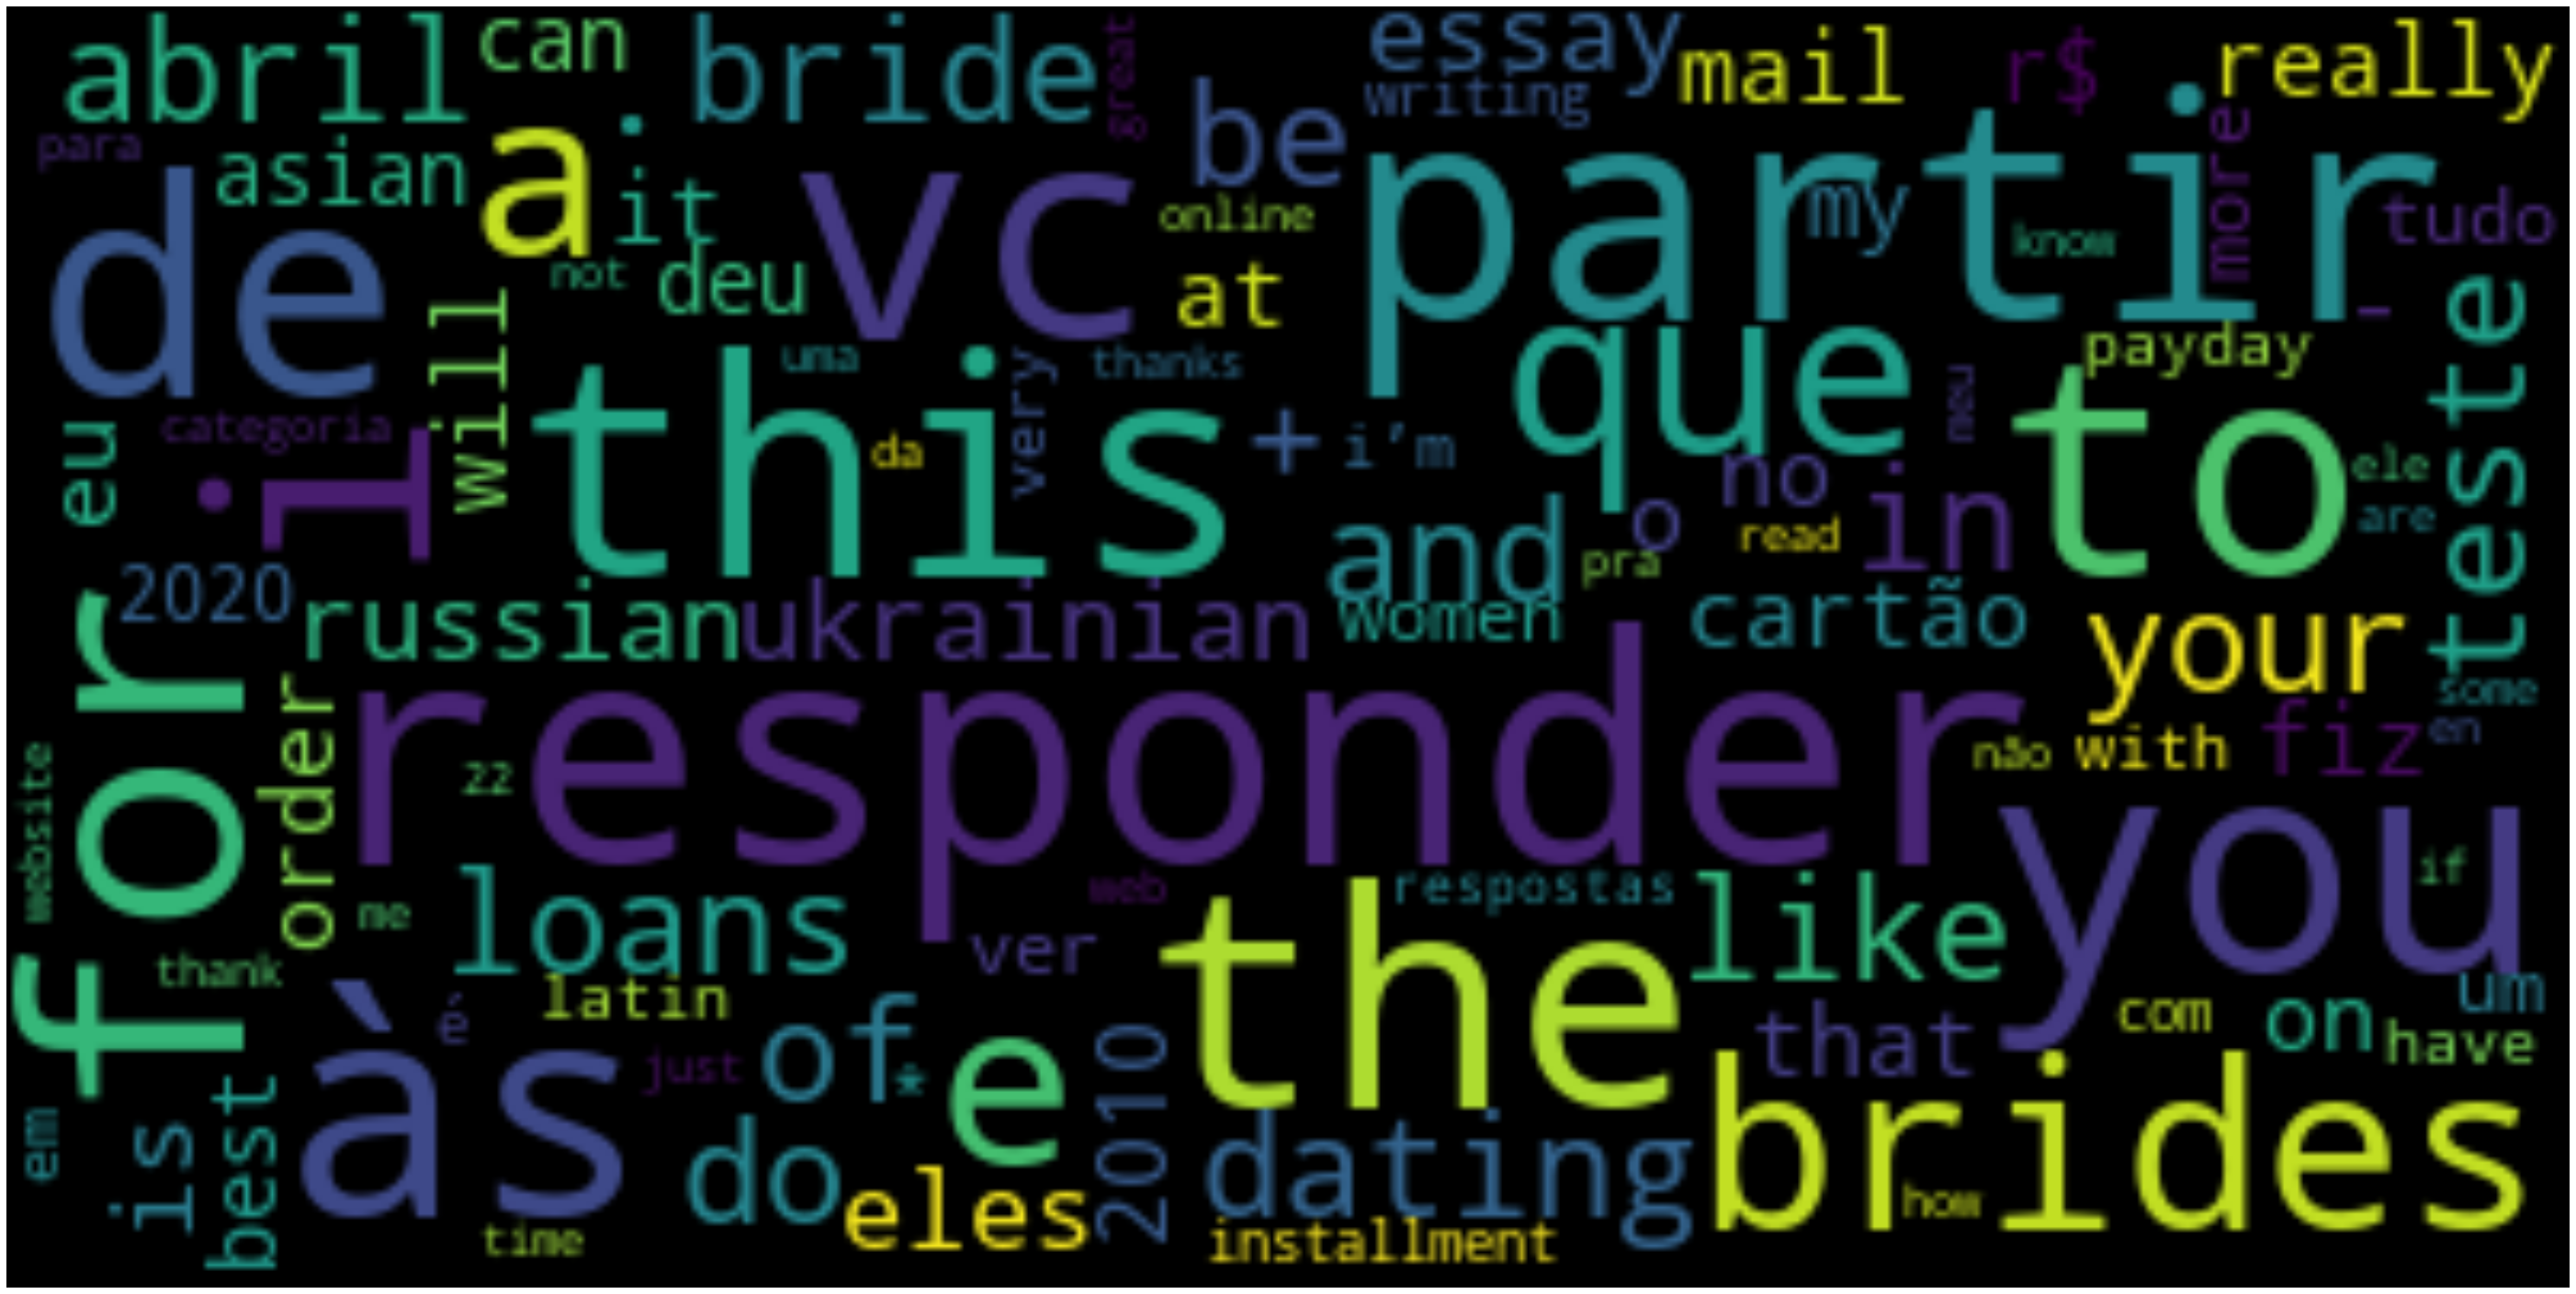

In [42]:
wordcloud_iphone = WordCloud(max_font_size=50, max_words=100, background_color="black").generate_from_frequencies(frequencies=conversor(list_iphone_rel))
wordcloud_iphone.to_file("wordcloud_iphone.png")
plt.figure(figsize = (50,50))
plt.imshow(wordcloud_iphone, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
rdd_android_join = rdd_android_freq.join(rdd_android_idf)
rdd_android_rel = rdd_android_join.map(computa_rel)

list_android_rel = rdd_android_rel.takeOrdered(100, key=lambda x: -x[1])
#list_android_rel
android_df = pd.DataFrame(list_android_rel, columns=["palavra", "relevancia"])
android_csv = android_df.to_csv("android.csv", index=False)

In [37]:
table_android = pd.read_csv("android.csv", sep=",")
table_android

palavra  relevancia
0   responder   10.098344
1          de    9.660192
2   respostas    9.487679
3        live    9.178607
4        chat    8.977052
..        ...         ...
95     marcos    7.205844
96     câmara    7.201787
97       site    7.199061
98        dos    7.196713
99     carlos    7.174209

[100 rows x 2 columns]

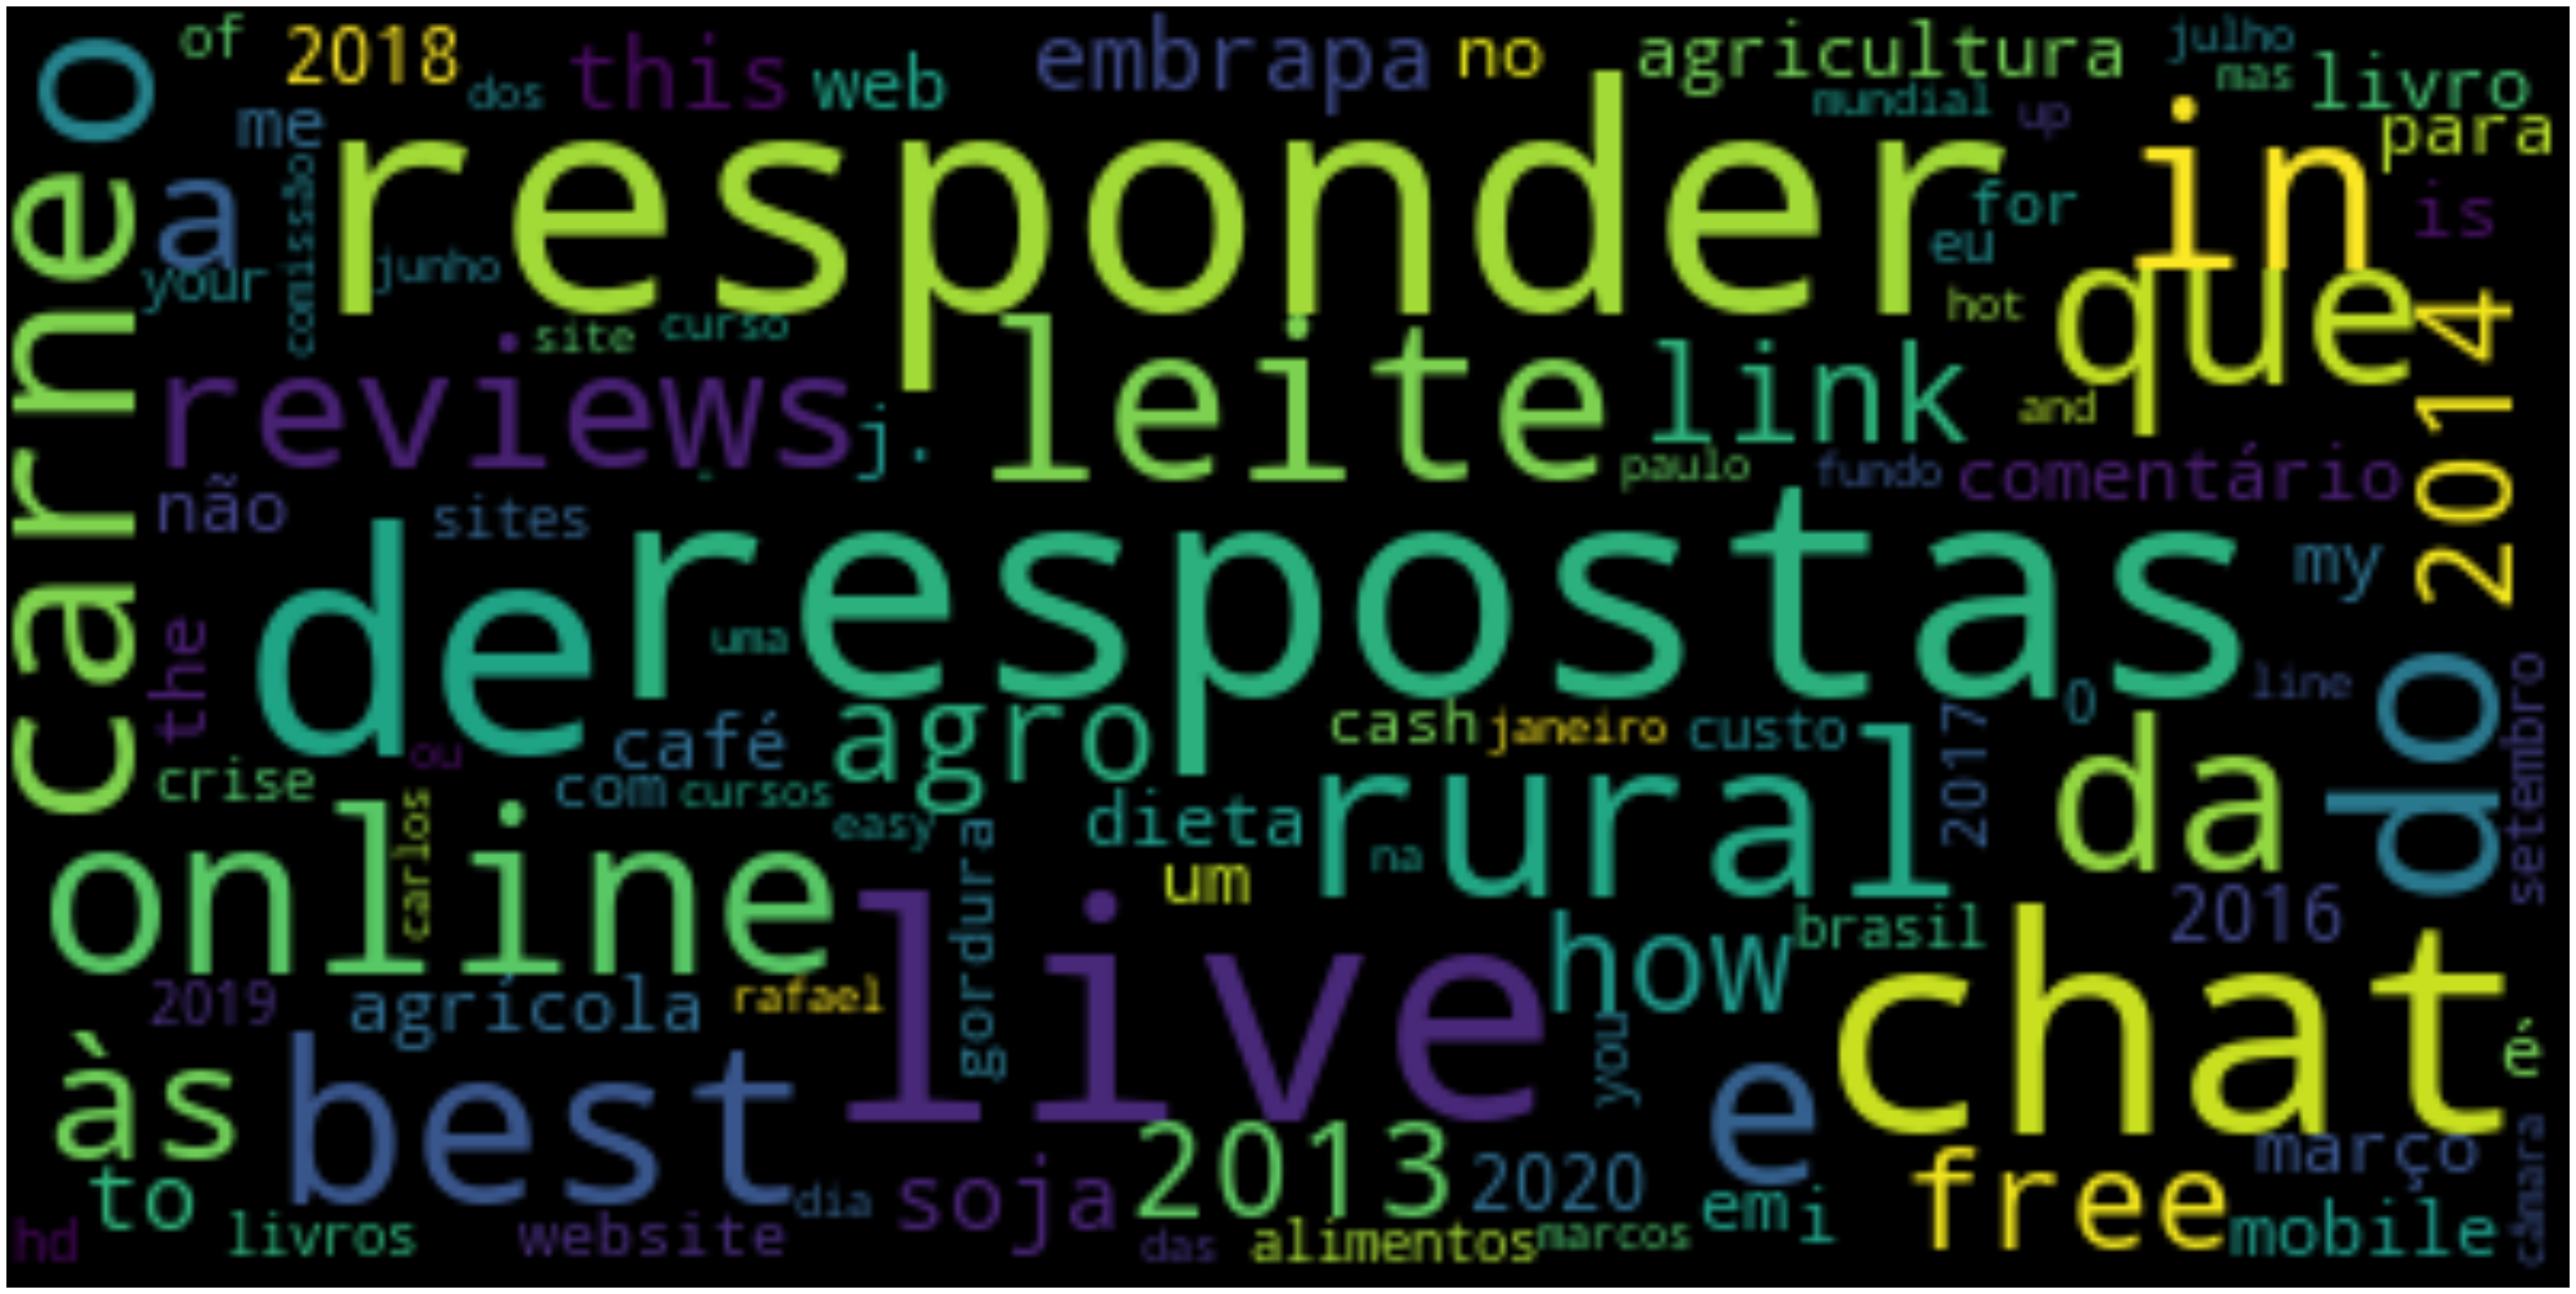

In [43]:
wordcloud_android = WordCloud(max_font_size=50, max_words=100, background_color="black").generate_from_frequencies(frequencies=conversor(list_android_rel))
wordcloud_android.to_file("wordcloud_android.png")
plt.figure(figsize = (50,50))
plt.imshow(wordcloud_android, interpolation="bilinear")
plt.axis("off")
plt.show()